In [1]:
%%capture
!pip install -r ../../model-archiver/model-store/youtubegoes5g/requirements.txt

In [2]:
from torch import nn
import torch

# Build model with non-linear activation function
class InterruptionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=29, out_features=200)
        self.layer_2 = nn.Linear(in_features=200, out_features=100)
        self.layer_3 = nn.Linear(in_features=100, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [3]:
import os
from pickle import load
from sklearn.preprocessing import StandardScaler

model = None

class MyHandler():
    def __init__(self, model):
        self.model = model

    def preprocess(self, data):
        """
        Transform raw input into model input data.
        """
        try:
            # Load scaler
            scaler = StandardScaler()
            scaler = load(open('../../model-archiver/model-store/youtubegoes5g/scaler.pkl', 'rb'))

            tensor_list = []
            for item in data:
                item = scaler.transform([item['data']])
                tensor_data = torch.tensor(item, dtype=torch.float32)  # Each instance as a tensor
                tensor_list.append(tensor_data)
            # Stack all tensors along a new dimension to create a single tensor
            combined_tensor = torch.cat(tensor_list, dim=0)
            return combined_tensor
        except Exception as e:
            raise ValueError("Failed to preprocess input data: ", e, "data received: ", data)

    def inference(self, model_input):
        """
        Perform model inference.
        """
        try:
            inference_list = []
            for tensor_data in model_input:
                with torch.no_grad():
                    output = torch.round(torch.sigmoid(self.model(tensor_data))).squeeze()
                #inference = output.cpu().numpy().tolist()
                inference_list.append(output)
            return inference_list
        except Exception as e:
            raise RuntimeError("Inference failed:", e)

    def postprocess(self, inference_output):
        """
        Convert model output to a list of predictions.
        """
        try:
            # Process each item in the batch
            result_list = []
            for result in inference_output:
                if result > 0:
                    result_list.append("Stall")
                else:
                    result_list.append("No Stall")
            return result_list
        except Exception as e:
            raise ValueError("Failed to postprocess output data: ", e)

    def handle(self, data):
        """
        Handle a prediction request.
        """
        try:
            model_input = self.preprocess(data)
            model_output = self.inference(model_input)
            return self.postprocess(model_output)
        except Exception as e:
            return [str(e)]

In [4]:
# Instantiate model and handler
serialized_file = "../../model-archiver/model-store/youtubegoes5g/model.pt"
    
model = InterruptionModel()
model.load_state_dict(torch.load(serialized_file, weights_only=True))
model.eval()
handler = MyHandler(model)

/opt/conda/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
import json
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import csv

# Tests params details
REPLICAS = 30
DURATION = 2 # minutes

# Define the sample data payload
# Sample data instances
SAMPLE_DATA = [
    {"data": [13, 13, 13, 0, 13, 13, 13, 13, -76, -76, -81, -76, -78.5, -76, -76, -7, -7, -12, -7, -9.5, -7, -7, 12, 12, 7, 12, 9.5, 12, 12]},
    {"data": [13, 13, 12, 0.4714045208, 13, 12.5, 13, 13, -81, -81, -82, -81, -81.5, -81, -81, -12, -12, -11, -12, -12, -12, -11.5, 7, 7, 2, 7, 4.5, 7, 7]},
    {"data": [14, 12, 11, 1.247219129, 14, 11.5, 12, 13, -82, -76, -76, -76, -79, -76, -76, -11, -7, -7, -7, -9, -7, -7, 2, 9, 9, 9, 5.5, 9, 9]},
    {"data": [13, 13, 7, 2.828427125, 13, 10, 13, 13, -103, -104, -104, -104, -104, -104, -103.5, -6, -12, -12, -12, -12, -12, -9, 14, 16, 16, 16, 15, 16, 16]},
    {"data": [6, 6, 4, 0.9428090416, 6, 5, 6, 6, -103, -102, -102, -102, -102.5, -102, -102, -15, -16, -16, -16, -16, -16, -15.5, -2, -1, -1, -1, -1.5, -1, -1]},
    {"data": [12, 12, 12, 0, 12, 12, 12, 12, -95, -92, -92, -92, -93.5, -92, -92, -11, -13, -13, -13, -13, -13, -12, 8, 9, 9, 9, 8.5, 9, 9]}
]

def get_data(num_instances=1):
    """
    Generate inference payload with the specified number of data instances.
    
    Args:
        num_instances (int): Number of data instances to include in the request.
                             Defaults to 1.
                             
    Returns:
        dict: JSON payload for the inference request.
    """
    # Ensure the number of instances does not exceed available data
    if num_instances > len(SAMPLE_DATA):
        raise ValueError(f"Requested {num_instances} instances, but only {len(SAMPLE_DATA)} are available.")

    # Create the payload with the requested number of instances
    return SAMPLE_DATA[:num_instances]

# Function to handle the inference request
def handle_request(num_instances=1):
    payload = get_data(num_instances)
    response = handler.handle(payload)
    return response

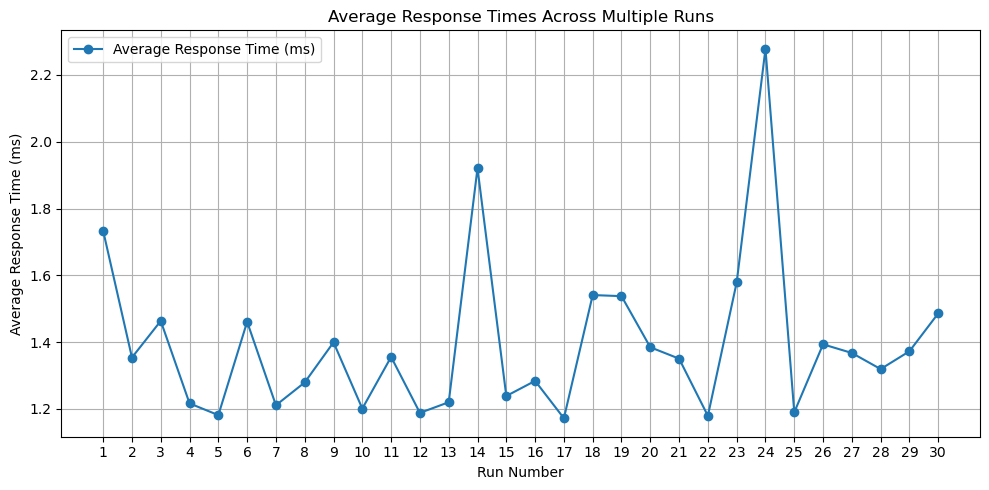

In [6]:
# Configuration: Interval, Duration, and Runs
n_seconds = 2  # Interval in seconds between requests
discard_first_n = 12  # Number of values to discard
num_instances = 1
csv_file = "test1P2I1.csv"  # Output CSV file
graph_file = "test1P2I1.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

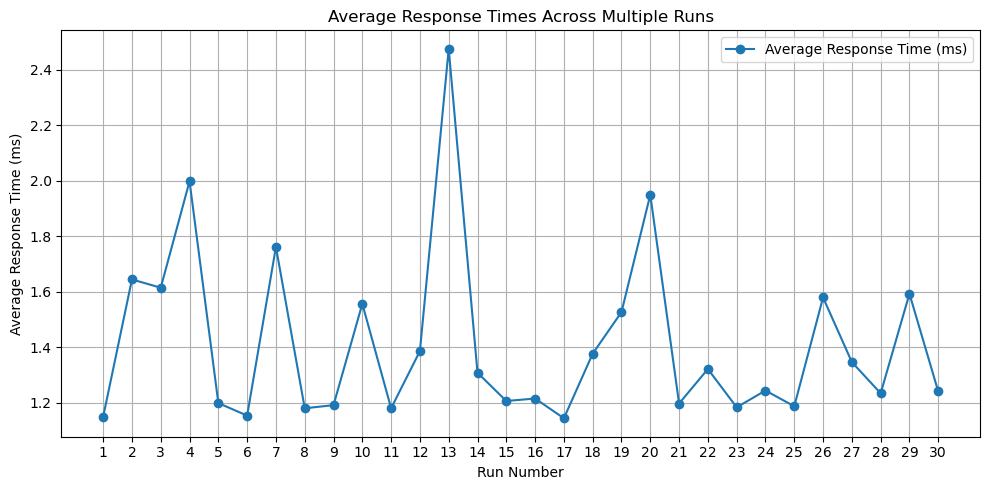

In [7]:
# Configuration: Interval, Duration, and Runs
n_seconds = 3  # Interval in seconds between requests
discard_first_n = 8  # Number of values to discard
num_instances = 1
csv_file = "test2P3I1.csv"  # Output CSV file
graph_file = "test2P3I1.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

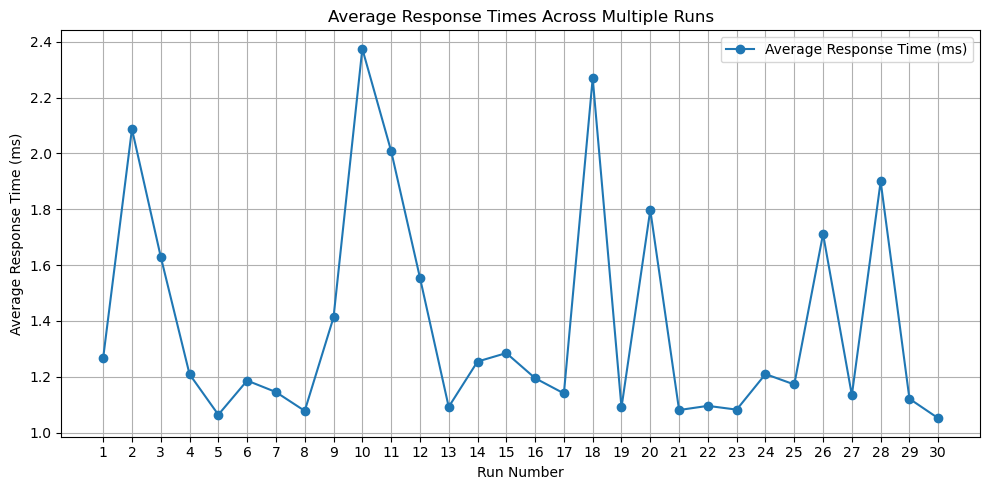

In [8]:
# Configuration: Interval, Duration, and Runs
n_seconds = 12  # Interval in seconds between requests
discard_first_n = 2  # Number of values to discard
num_instances = 1
csv_file = "test3P12I1.csv"  # Output CSV file
graph_file = "test3P12I1.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

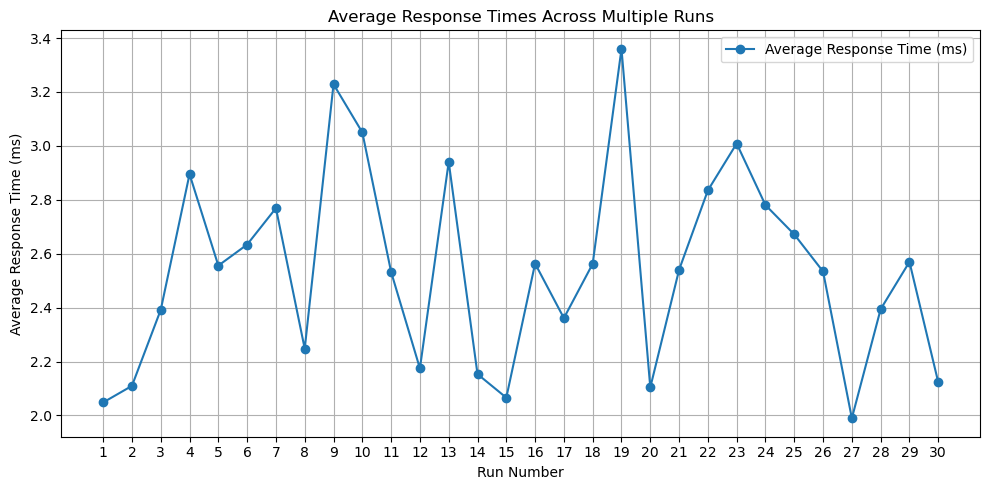

In [9]:
# Configuration: Interval, Duration, and Runs
n_seconds = 2  # Interval in seconds between requests
discard_first_n = 12  # Number of values to discard
num_instances = 4
csv_file = "test4P2I4.csv"  # Output CSV file
graph_file = "test4P2I4.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

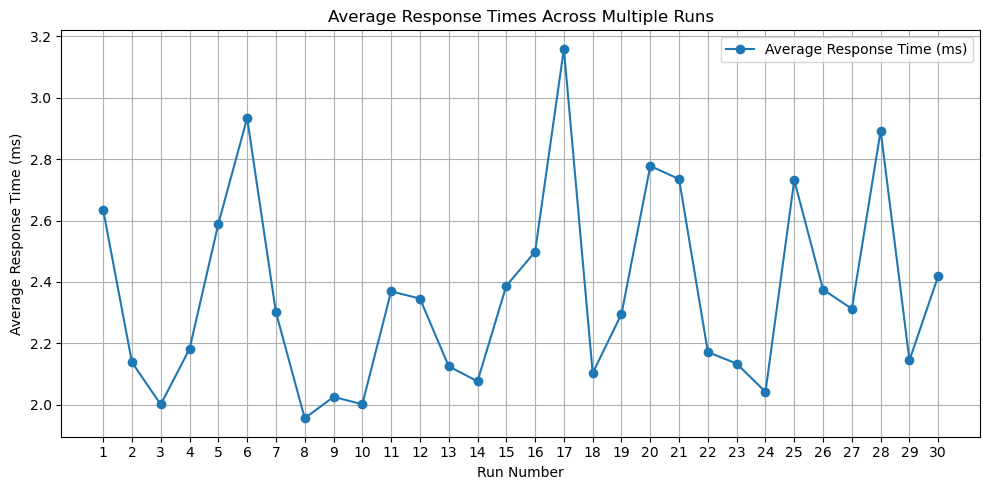

In [10]:
# Configuration: Interval, Duration, and Runs
n_seconds = 3  # Interval in seconds between requests
discard_first_n = 8  # Number of values to discard
num_instances = 4
csv_file = "test5P3I4.csv"  # Output CSV file
graph_file = "test5P3I4.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

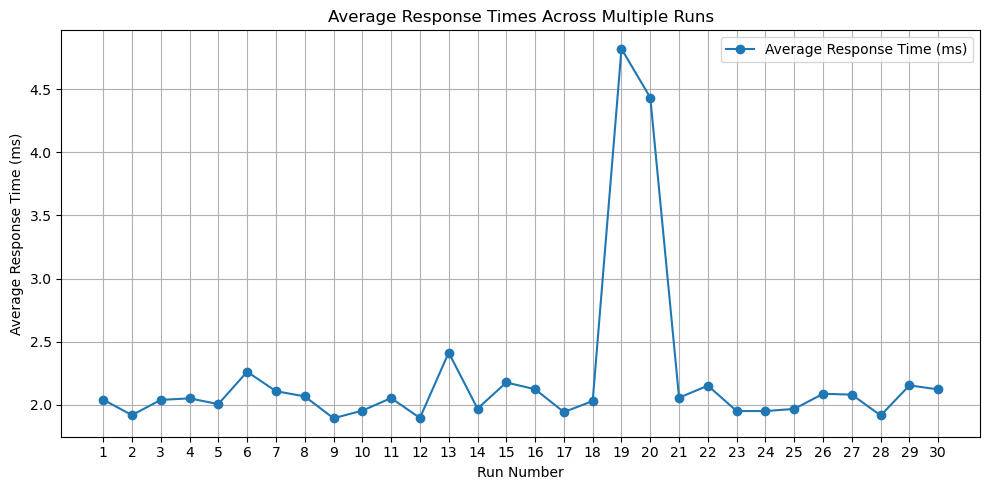

In [11]:
# Configuration: Interval, Duration, and Runs
n_seconds = 12  # Interval in seconds between requests
discard_first_n = 2  # Number of values to discard
num_instances = 4
csv_file = "test6P12I4.csv"  # Output CSV file
graph_file = "test6P12I4.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

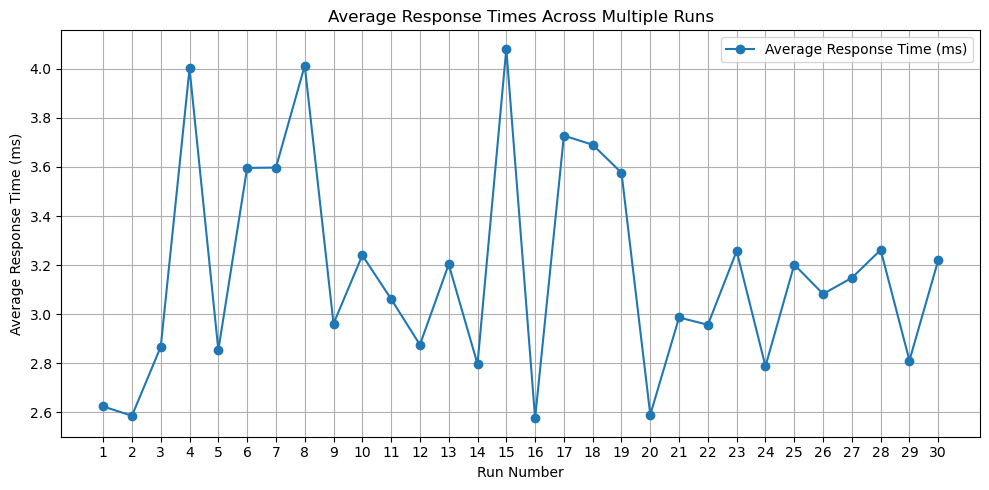

In [12]:
# Configuration: Interval, Duration, and Runs
n_seconds = 2  # Interval in seconds between requests
discard_first_n = 12  # Number of values to discard
num_instances = 6
csv_file = "test7P2I6.csv"  # Output CSV file
graph_file = "test7P2I6.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

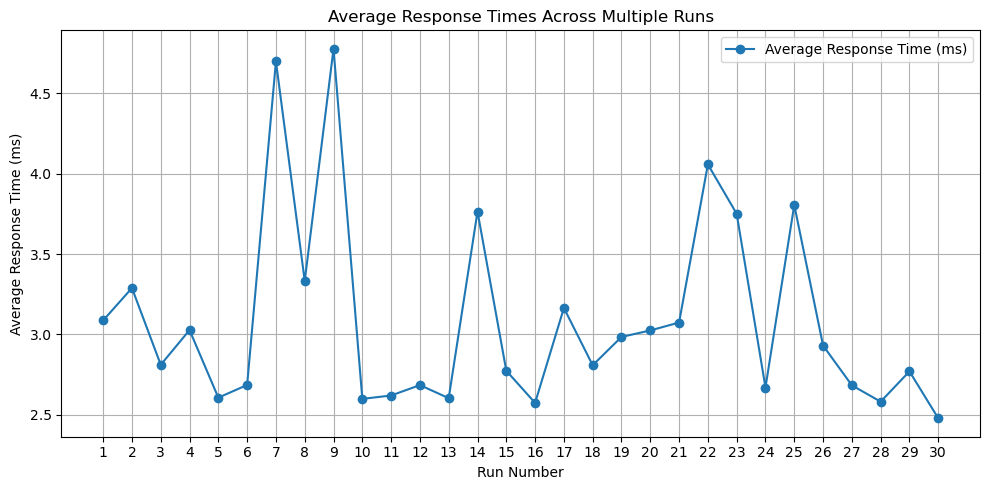

In [13]:
# Configuration: Interval, Duration, and Runs
n_seconds = 3  # Interval in seconds between requests
discard_first_n = 8  # Number of values to discard
num_instances = 6
csv_file = "test8P3I6.csv"  # Output CSV file
graph_file = "test8P3I6.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

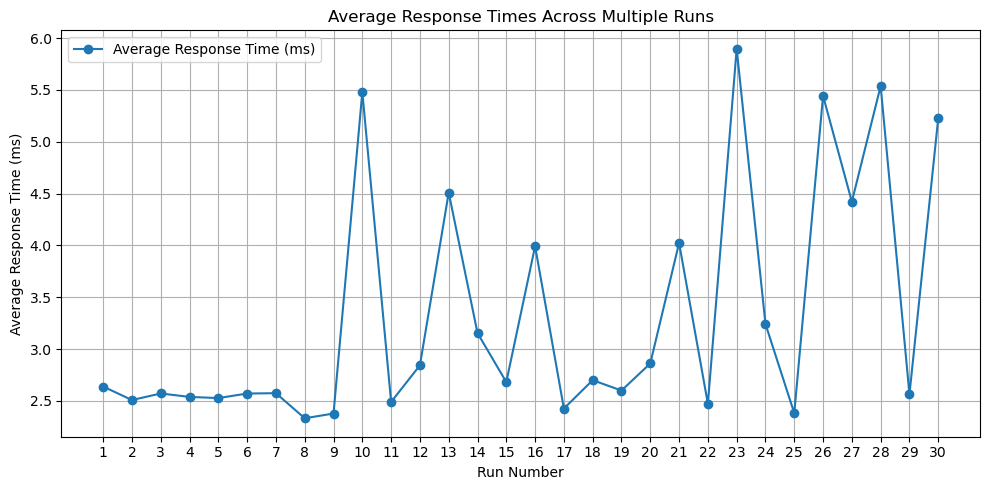

In [14]:
# Configuration: Interval, Duration, and Runs
n_seconds = 12  # Interval in seconds between requests
discard_first_n = 2  # Number of values to discard
num_instances = 6
csv_file = "test9P12I6.csv"  # Output CSV file
graph_file = "test9P12I6.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handle_request(num_instances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()